# Goal: predict whether a loan will default or not

---
#### Target variable: `zeroBalCode` 
* Type: **Categorical** 
* Model type: Classification 
* Data: 
    - "0" means "Closed" (i.e. a successful outcome for Fannie Mae)
    - "1" means "Default" (i.e. a negative outcome)

---
#### Inputs that we want to build text boxes/etc for:
* TBD

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip install pycaret
from pycaret.classification import *
#from pycaret.regression import *

from sklearn.feature_selection import VarianceThreshold

# Importing the data

In [113]:
dforig=pd.read_csv("data/MLReady/FM_FULL_EPOCH2_MLReady.csv")
df=dforig.copy()
df.head()
print(f'Epoch 2: {df.origYear.unique().tolist()}')

Epoch 2: [2009, 2010, 2011, 2012, 2013]


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119696 entries, 0 to 119695
Data columns (total 32 columns):
Unnamed: 0            119696 non-null int64
origChannel           119696 non-null int64
origIntRate           119696 non-null float64
origUPB               119696 non-null int64
origLTV               119696 non-null int64
numBorrowers          119696 non-null int64
origDebtIncRatio      119696 non-null int64
borrCreditScore       119696 non-null int64
loanPurp              119696 non-null int64
zipCode               119696 non-null int64
pMIperct              119696 non-null float64
mortInsType           119696 non-null int64
bestCreditScore       119696 non-null int64
worstCreditScore      119696 non-null int64
avgCreditScore        119696 non-null int64
bankNumber            119696 non-null int64
stateNumber           119696 non-null int64
mSA                   119696 non-null int64
zeroBalCode           119696 non-null int64
fmacRateMax           119696 non-null float64
fma

In [115]:
# Get the data into the data types you want:
df = df.astype({
    'origLTV':'int'
    , 'numBorrowers':'int'
    , 'origDebtIncRatio':'int'
    , 'borrCreditScore':'int'
    , 'mortInsType':'int'
    , 'bestCreditScore':'int'
    , 'worstCreditScore':'int'
    , 'avgCreditScore':'int'
    , 'zeroBalCode':'object'}
)

# Pre-Processing: Feature Elimination

Remove each features' dataseries and remove features that:
* Step 1: Remove the index
* Step 2: Have zero to low variance
* Step 3: Are not part of a either a "closed" event or a "default" event
* Step 4: Any unique identifiers that are not helpful in predicting the target

### Step 1: Remove the index

In [116]:
# There is only one column that matches the above: the index
df.drop(['Unnamed: 0'], 1, inplace=True)

### Step 2: Have zero to low variance

In [117]:
X = df.loc[:, df.columns != 'zeroBalCode']
y = df['zeroBalCode']

rows, cols = X.shape
print(f'There are currently {cols} features and {rows} rows')
print(type(X))

There are currently 30 features and 119696 rows
<class 'pandas.core.frame.DataFrame'>


In [118]:
# What is the variance?
import statistics as stat
for c in X.columns.tolist():
    varianceNb = stat.variance(X[c])
    print(f'{c}: {varianceNb}')

origChannel: 0.8790166775255016
origIntRate: 0.3563562677994478
origUPB: 15948893967.594942
origLTV: 241.3171404652037
numBorrowers: 0.2544270766865069
origDebtIncRatio: 107.87451262617431
borrCreditScore: 2408.2562385113874
loanPurp: 0.2500110113673438
zipCode: 103990.91998733362
pMIperct: 41.47753906342591
mortInsType: 0.1024199561819053
bestCreditScore: 2383.7670040166613
worstCreditScore: 2400.1981184373512
avgCreditScore: 2295.243334465609
bankNumber: 607.1906651982089
stateNumber: 258.4066966439463
mSA: 214122843.6163899
fmacRateMax: 0.3898346584274688
fmacRateMin: 0.35260789547910026
fmacRateAvg: 0.36812059462000274
fmacRateVolatility: 0.0006216519318082418
fredRate: 0.4583382127920872
rateDiffAbove: 0.1778516970944502
rateDiffBelow: 0.1544630784964568
rateDiffAvg: 0.1618216341730691
rateDiffAbovePct: 0.008391784161827086
rateDiffBelowPct: 0.008224413710353574
rateDiffAvgPct: 0.008152868422471966
origYear: 1.794211791486425
origMonth: 11.151953164734818


In [119]:
# Create VarianceThreshold object with a variance with a threshold of 0.5
threshold=0.5
thresholder = VarianceThreshold(threshold=threshold)

# Conduct variance thresholding
X_high_variance = thresholder.fit_transform(X)

rows, cols = X_high_variance.shape
print(f'There are currently {cols} features with a higher variance than {threshold} for {rows} rows')

There are currently 15 features with a higher variance than 0.5 for 119696 rows


In [120]:
# fit_transform() returns a nparray but the column names are lost
dfX_High_variance = pd.DataFrame(X_high_variance)
dfX_High_variance.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2.0,348000.0,87.0,50.0,689.0,51.0,25.0,689.0,689.0,689.0,80.0,49.0,0.0,2009.0,2.0
1,3.0,195000.0,52.0,54.0,703.0,82.0,0.0,810.0,703.0,756.0,4.0,32.0,12100.0,2009.0,2.0
2,2.0,342000.0,80.0,54.0,746.0,981.0,0.0,746.0,746.0,746.0,3.0,50.0,42660.0,2009.0,2.0
3,1.0,93000.0,70.0,50.0,780.0,496.0,0.0,780.0,780.0,780.0,54.0,23.0,0.0,2009.0,2.0
4,1.0,182000.0,76.0,22.0,802.0,18.0,0.0,802.0,776.0,789.0,45.0,20.0,14460.0,2009.0,2.0


In [121]:
dfOptimized = df.copy()
dfOptimized.columns.to_list()

['origChannel',
 'origIntRate',
 'origUPB',
 'origLTV',
 'numBorrowers',
 'origDebtIncRatio',
 'borrCreditScore',
 'loanPurp',
 'zipCode',
 'pMIperct',
 'mortInsType',
 'bestCreditScore',
 'worstCreditScore',
 'avgCreditScore',
 'bankNumber',
 'stateNumber',
 'mSA',
 'zeroBalCode',
 'fmacRateMax',
 'fmacRateMin',
 'fmacRateAvg',
 'fmacRateVolatility',
 'fredRate',
 'rateDiffAbove',
 'rateDiffBelow',
 'rateDiffAvg',
 'rateDiffAbovePct',
 'rateDiffBelowPct',
 'rateDiffAvgPct',
 'origYear',
 'origMonth']

In [122]:
dfOptimized.drop([
        'borrCreditScore'
        , 'bestCreditScore'
        , 'avgCreditScore'
        # For Tableau, not model prediction:
        , 'rateDiffAbove'
        , 'rateDiffBelow'
        , 'rateDiffAvg'
        , 'rateDiffAbovePct'
        , 'rateDiffBelowPct'
        , 'rateDiffAvgPct'
        , 'fmacRateMax'
        , 'fmacRateMin'
        , 'fmacRateAvg'
        , 'mSA'
        , 'fmacRateVolatility'
        , 'fredRate'
        , 'mortInsType'
    ]
    , axis=1
    , inplace=True
)

dfOptimized.head()

,origChannel,origIntRate,origUPB,origLTV,numBorrowers,origDebtIncRatio,loanPurp,zipCode,pMIperct,worstCreditScore,bankNumber,stateNumber,zeroBalCode,origYear,origMonth
0,2,5.125,348000,87,1,50,2,51,25.0,689,80,49,1,2009,2
1,3,4.625,195000,52,2,54,1,82,0.0,703,4,32,0,2009,2
2,2,4.875,342000,80,1,54,1,981,0.0,746,3,50,0,2009,2
3,1,5.375,93000,70,1,50,1,496,0.0,780,54,23,1,2009,2
4,1,4.875,182000,76,2,22,1,18,0.0,776,45,20,0,2009,2


In [123]:
# What is the variance?
import statistics as stat
for c in dfOptimized.columns.tolist():
    varianceNb = stat.variance(dfOptimized[c])
    print(f'{c}: {varianceNb}')

origChannel: 0.8790166775255016
origIntRate: 0.3563562677994478
origUPB: 15948893967.594942
origLTV: 241.3171404652037
numBorrowers: 0.2544270766865069
origDebtIncRatio: 107.87451262617431
loanPurp: 0.2500110113673438
zipCode: 103990.91998733362
pMIperct: 41.47753906342591
worstCreditScore: 2400.1981184373512
bankNumber: 607.1906651982089
stateNumber: 258.4066966439463
zeroBalCode: 0.11768339548176236
origYear: 1.794211791486425
origMonth: 11.151953164734818


# PCA 

https://pycaret.org/pca/ documentation:
* `pca_components = 5` - only consider the top 5 features sorted by high variance
* `pca_components = .95` - only include features that account for 95% of the variance

In [125]:
model_setup = setup(
    dfOptimized
    , target = 'zeroBalCode' # PyCaret will list this as "Label"
    , pca = True, pca_components = 5 # Use the top n features only
    , ignore_low_variance = True
    , categorical_features = [
            'origChannel'
            , 'numBorrowers'
            , 'loanPurp'
            , 'zipCode'
            , 'bankNumber'
            , 'stateNumber'
            , 'origYear'
            , 'origMonth'
        ]
        , numeric_features = [
            'origIntRate'
            , 'origUPB'
            , 'origLTV'
            , 'pMIperct'
            , 'origDebtIncRatio'
            , 'worstCreditScore'
        ]
)

# session_id - if you ever want to reprint the results later, pass the session_id to setup()
#      and it will run the setup using the same split of test/train

 
Setup Succesfully Completed!


,Description,Value
0,session_id,4583
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(119696, 15)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,8
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


# Pycaret - Setup with categorical definition

### Use feature engineering, polynomial features, trig feats, PCA

### Use feature engineering, polynomial features, trig feats

## Compare Models with blacklist exclusions

In [126]:
# Can influence performance by reducing # of folds (10 is def.) or adding blacklists/exclusions
# Regression has about 21 models
# Classification has about 15 models
model_results=compare_models()
model_results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Naive Bayes,0.8637,0.7077,0,0,0,0
1,Ridge Classifier,0.8637,0,0,0,0,0
2,Quadratic Discriminant Analysis,0.8637,0.7283,0,0,0,0
3,Linear Discriminant Analysis,0.8637,0.7407,0,0,0,0
4,Extreme Gradient Boosting,0.8627,0.7512,0.0201,0.4587,0.0383,0.0264
5,Gradient Boosting Classifier,0.8624,0.7495,0.0368,0.4831,0.0673,0.0477
6,CatBoost Classifier,0.8598,0.7387,0.0517,0.3981,0.0907,0.0611
7,Ada Boost Classifier,0.859,0.7378,0.0595,0.3962,0.1025,0.0692
8,Extra Trees Classifier,0.859,0.7137,0.0429,0.3512,0.076,0.0485
9,Light Gradient Boosting Machine,0.8587,0.7332,0.0429,0.3439,0.076,0.0479


# Gradient Boosting Classifier	is the winner
Good Accuracy, 2nd highest AUC, best Precision

In [127]:
gradBoosted = create_model('gbc', fold = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8663,0.7662,0.0263,0.7500,0.0508,0.0420
1,0.8604,0.7408,0.0263,0.3333,0.0488,0.0295
2,0.8604,0.7605,0.0088,0.2000,0.0168,0.0054
3,0.8640,0.7559,0.0351,0.5000,0.0656,0.0486
4,0.8604,0.7343,0.0439,0.3846,0.0787,0.0523
5,0.8711,0.7483,0.0614,0.8750,0.1148,0.0987
6,0.8592,0.7787,0.0696,0.4211,0.1194,0.0837
7,0.8628,0.7350,0.0348,0.5000,0.0650,0.0480
8,0.8662,0.7070,0.0351,0.6667,0.0667,0.0538
9,0.8530,0.7688,0.0263,0.2000,0.0465,0.0153


In [128]:
# Test out XGBoost just to see since it was close 2nd
xgb = create_model('xgboost', fold = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8628,0.7722,0.0088,0.3333,0.0171,0.0102
1,0.8580,0.7391,0.0000,0.0000,0.0000,-0.0116
2,0.8663,0.7662,0.0175,1.0000,0.0345,0.0299
3,0.8652,0.7501,0.0263,0.6000,0.0504,0.0394
4,0.8604,0.7448,0.0263,0.3333,0.0488,0.0295
5,0.8663,0.7453,0.0351,0.6667,0.0667,0.0538
6,0.8604,0.7814,0.0261,0.3750,0.0488,0.0315
7,0.8640,0.7333,0.0261,0.6000,0.0500,0.0390
8,0.8614,0.7149,0.0088,0.2500,0.0169,0.0078
9,0.8626,0.7651,0.0263,0.4286,0.0496,0.0344


# Results
gbc has 2x the F1 score that xgboost has

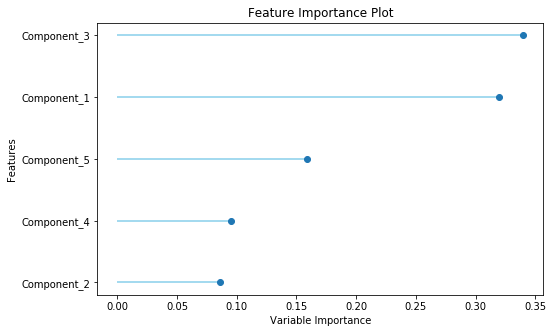

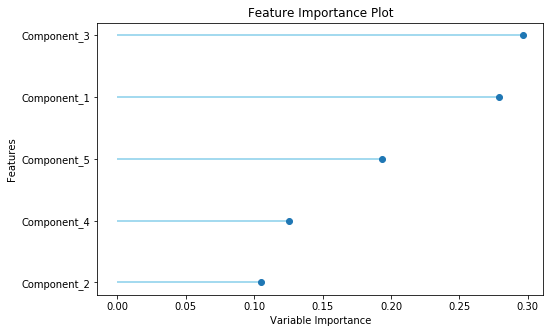

In [130]:
plot_model(gradBoosted, plot='feature')
plot_model(xgb, plot='feature')

In [131]:
tuned_gradBoosted = tune_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8556,0.7037,0.0789,0.3600,0.1295,0.0847
1,0.8425,0.6853,0.0789,0.2500,0.1200,0.0585
2,0.8532,0.6961,0.1140,0.3714,0.1745,0.1181
3,0.8496,0.6797,0.0702,0.2857,0.1127,0.0624
4,0.8449,0.6708,0.1053,0.3000,0.1558,0.0917
5,0.8532,0.7106,0.1667,0.4043,0.2360,0.1701
6,0.8449,0.7116,0.0957,0.2973,0.1447,0.0835
7,0.8461,0.6422,0.1043,0.3158,0.1569,0.0952
8,0.8423,0.6692,0.0789,0.2500,0.1200,0.0584
9,0.8542,0.7135,0.1491,0.4048,0.2179,0.1561


## Ensemble models

In [132]:
gbc_bagged = ensemble_model(gradBoosted)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8616,0.7712,0.0088,0.2500,0.0169,0.0078
1,0.8592,0.7460,0.0263,0.3000,0.0484,0.0270
2,0.8616,0.7735,0.0088,0.2500,0.0169,0.0078
3,0.8640,0.7571,0.0263,0.5000,0.0500,0.0369
4,0.8616,0.7385,0.0526,0.4286,0.0938,0.0660
5,0.8663,0.7529,0.0351,0.6667,0.0667,0.0538
6,0.8580,0.7776,0.0348,0.3333,0.0630,0.0380
7,0.8640,0.7316,0.0261,0.6000,0.0500,0.0390
8,0.8626,0.7055,0.0088,0.3333,0.0171,0.0102
9,0.8578,0.7659,0.0175,0.2222,0.0325,0.0128


## Evaluate Models
F1 (a.k.a. F score): closest to 1.0 is winner

SHAP - a way to evaluate ML models
* https://pycaret.org/interpret-model/
* https://shap.readthedocs.io/en/latest/

Examples: 
* https://medium.com/@shekharshashank1/2-words-code-to-compare-20-ml-regression-models-with-pycaret-8ed70c62a6b7
* https://www.linkedin.com/pulse/credit-card-fault-detection-using-pycaret-sagar-vasaikar/?articleId=6657385017775321088
* https://www.kaggle.com/frtgnn/pycaret-introduction-classification-regression
* https://prog.world/introducing-pycaret-an-open-low-code-python-machine-learning-library/
* https://towardsdatascience.com/announcing-pycaret-an-open-source-low-code-machine-learning-library-in-python-4a1f1aad8d46

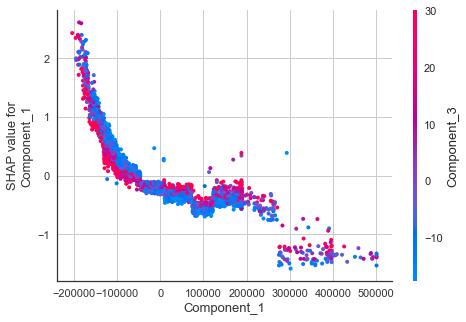

In [143]:
interpret_model(
    estimator=gradBoosted
    , plot='correlation'
)

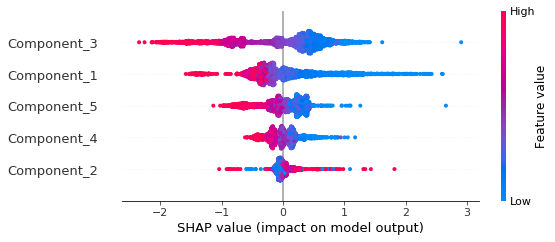

In [138]:
interpret_model(
    estimator=gradBoosted
    , plot='summary'
)

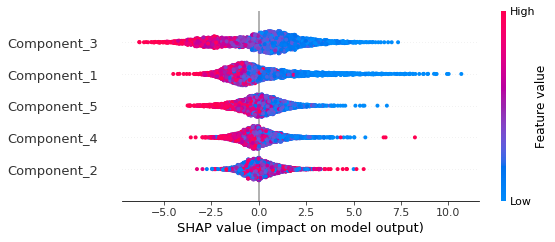

In [139]:
interpret_model(estimator=tuned_gradBoosted, plot='summary')

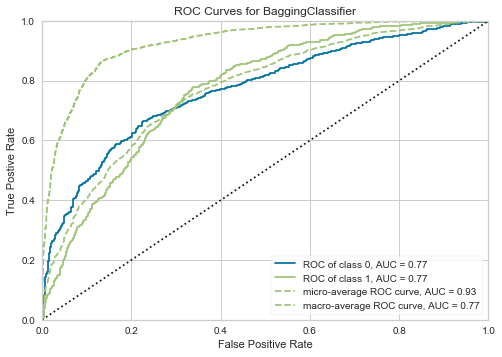

In [141]:
# Cannot do an ensemble / tree-based model
# interpret_model(estimator=gbc_bagged, plot='summary')

# Look at the ROC curve
plot_model(gbc_bagged)

In [144]:
interpret_model(
    estimator=gradBoosted
    , plot='reason'
)

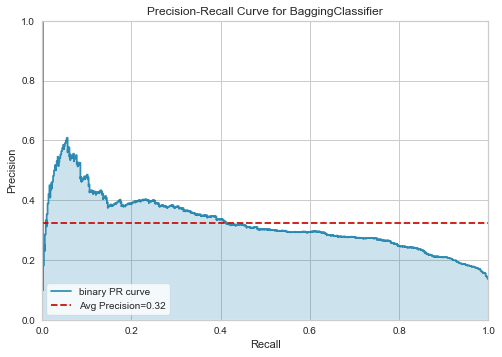

In [145]:
# Precision recall curve is good for a BaggingClassifier
plot_model(
    estimator=gbc_bagged
    , plot='pr'
)

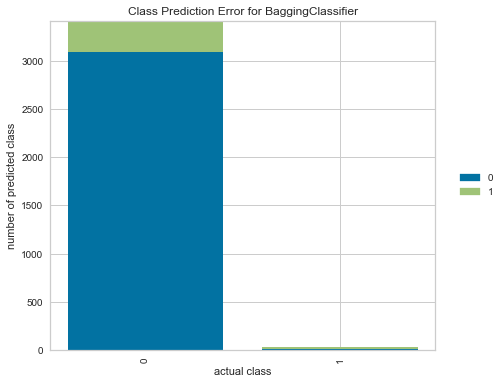

In [146]:
# BaggingClassifier - look at the class prediction error rate
plot_model(
    estimator=gbc_bagged
    , plot='error'
)

In [147]:
# Cannot use Feature Selection on a tree-based classifier:
evaluate_model(gbc_bagged)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [151]:
# You can get the Feature Selection from gradBoosted
evaluate_model(gradBoosted)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [148]:
print(gradBoosted)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=4583, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [149]:
print(gbc_bagged)

BaggingClassifier(base_estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                            criterion='friedman_mse',
                                                            init=None,
                                                            learning_rate=0.1,
                                                            loss='deviance',
                                                            max_depth=3,
                                                            max_features=None,
                                                            max_leaf_nodes=None,
                                                            min_impurity_decrease=0.0,
                                                            min_impurity_split=None,
                                                            min_samples_leaf=1,
                                                            min_samples_split=2,
                                              

In [150]:
dfOptimized.head()

# Todo: 
#    - Dictionary to map bankNumber to Bank
#    - Dictionary to map stateNumber to State
#    - Add to pycaret setup using label encoding instead of one-hot encoding
# Possibly bin the credit scores
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization.html
# Model stacking or blend models to try to increase the Accuracy

,origChannel,origIntRate,origUPB,origLTV,numBorrowers,origDebtIncRatio,loanPurp,zipCode,pMIperct,worstCreditScore,bankNumber,stateNumber,zeroBalCode,origYear,origMonth
0,2,5.125,348000,87,1,50,2,51,25.0,689,80,49,1,2009,2
1,3,4.625,195000,52,2,54,1,82,0.0,703,4,32,0,2009,2
2,2,4.875,342000,80,1,54,1,981,0.0,746,3,50,0,2009,2
3,1,5.375,93000,70,1,50,1,496,0.0,780,54,23,1,2009,2
4,1,4.875,182000,76,2,22,1,18,0.0,776,45,20,0,2009,2


# Encoding

Label encoding is converting categoricals (like "Texas") to a static number (30), in which you can later perform a lookup

One-hot encoding is better when you have dichotomous *Yes/No* and it will make columns for those. 

Rule of thumb: Use label encoding when you have a large # of distinct values in your categorical feature, and use one-hot encoding when you have a small # of distinct values

# Normalization
https://pycaret.org/normalization/

> `normalize: bool, default = False` - When set to True, the feature space is transformed using the normalized_method param. **Generally, linear algorithms perform better with normalized data** however, the results may vary and it is advised to run multiple experiments to evaluate the benefit of normalization.

In [152]:
model_setup = setup(
    dfOptimized
    , target = 'zeroBalCode' # PyCaret will list this as "Label"
    , pca = False 
    , ignore_low_variance = True
    , normalize = True
    , categorical_features = [
            'origChannel'
            , 'numBorrowers'
            , 'loanPurp'
            , 'zipCode'
            , 'bankNumber'
            , 'stateNumber'
            , 'origYear'
            , 'origMonth'
        ]
        , numeric_features = [
            'origIntRate'
            , 'origUPB'
            , 'origLTV'
            , 'pMIperct'
            , 'origDebtIncRatio'
            , 'worstCreditScore'
        ]
)

# session_id - if you ever want to reprint the results later, pass the session_id to setup()
#      and it will run the setup using the same split of test/train

 
Setup Succesfully Completed!


,Description,Value
0,session_id,2195
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(119696, 15)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,8
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [153]:
dfOptimized.head()

,origChannel,origIntRate,origUPB,origLTV,numBorrowers,origDebtIncRatio,loanPurp,zipCode,pMIperct,worstCreditScore,bankNumber,stateNumber,zeroBalCode,origYear,origMonth
0,2,5.125,348000,87,1,50,2,51,25.0,689,80,49,1,2009,2
1,3,4.625,195000,52,2,54,1,82,0.0,703,4,32,0,2009,2
2,2,4.875,342000,80,1,54,1,981,0.0,746,3,50,0,2009,2
3,1,5.375,93000,70,1,50,1,496,0.0,780,54,23,1,2009,2
4,1,4.875,182000,76,2,22,1,18,0.0,776,45,20,0,2009,2


In [155]:
model_results = compare_models(fold=2)

In [156]:
model_results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extreme Gradient Boosting,0.865,0.7738,0.0543,0.5478,0.0987,0.0761
1,Random Forest Classifier,0.863,0.6545,0.0254,0.4541,0.0481,0.0341
2,Gradient Boosting Classifier,0.8624,0.7583,0.056,0.4625,0.0997,0.0723
3,CatBoost Classifier,0.8621,0.7669,0.0701,0.4598,0.1215,0.0889
4,Light Gradient Boosting Machine,0.8598,0.7575,0.1208,0.4457,0.1901,0.1402
5,Extra Trees Classifier,0.8596,0.6918,0.0228,0.3005,0.0423,0.0237
6,Logistic Regression,0.8564,0.7524,0.0849,0.3811,0.1389,0.0938
7,Ada Boost Classifier,0.8559,0.7553,0.1173,0.4043,0.1815,0.128
8,Ridge Classifier,0.8515,0,0.0648,0.3016,0.1064,0.0605
9,K Neighbors Classifier,0.8514,0.6441,0.0797,0.3191,0.1275,0.0773


In [157]:
gradBoosted2 = create_model('gbc', fold = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8580,0.7601,0.0351,0.3077,0.0630,0.0361
1,0.8711,0.7919,0.0789,0.7500,0.1429,0.1201
2,0.8675,0.7869,0.0702,0.6154,0.1260,0.1009
3,0.8652,0.7570,0.0614,0.5385,0.1102,0.0847
4,0.8675,0.7633,0.0614,0.6364,0.1120,0.0902
5,0.8616,0.7490,0.0526,0.4286,0.0938,0.0660
6,0.8592,0.7759,0.0522,0.4000,0.0923,0.0626
7,0.8616,0.7572,0.0435,0.4545,0.0794,0.0568
8,0.8626,0.7879,0.0439,0.4545,0.0800,0.0574
9,0.8722,0.7913,0.1053,0.7059,0.1832,0.1533


# To increase Recall
If Recall is low, that means that if you deploy this and try it against newer/incoming data, it will not be able to have good results.

To fix situations where you have a dichotomous feature (True/False) and True is 95% of the data - if you use random sampling, you will always have a low recall. Fix it by oversampling - create 50/50 split of test so the model can figure out how to differentiate better.

In [ ]:
tuned_gradBoosted3 = tune_model('gbc')

In [161]:
tuned_gradBoosted3

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.03, loss='deviance', max_depth=50,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2195, subsample=0.15000000000000002,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)

# Calibrate the model
This function takes the input of trained estimator and performs probability calibration with sigmoid or isotonic regression. The output prints a score  grid that shows Accuracy, AUC, Recall, Precision, F1 and Kappa by fold (default = 10 Fold). The output of the original estimator and the calibrated estimator (created using this function) might not differ much. In order to see the calibration differences, use ‘calibration’ plot in plot_model to see the difference before and after.

In [162]:
dt_boosted = create_model('lightgbm', ensemble = True, method = 'Boosting')

IntProgress(value=0, description='Processing: ', max=14)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:49:21
Status,. . . . . . . . . . . . . . . . . .,Fitting Fold 3 of 10
ETC,. . . . . . . . . . . . . . . . . .,15.48 Minutes Remaining


,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8449,0.7186,0.0614,0.2333,0.0972,0.0430
1,0.8640,0.7537,0.1316,0.5000,0.2083,0.1608


KeyboardInterrupt: 

In [ ]:
# Light Gradient Boosting Machine - fast

In [ ]:
#calibrate trained and boosted model
calibrated_dt = calibrate_model(dt_boosted)